# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

In [13]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# Plot images inline in the notebook
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


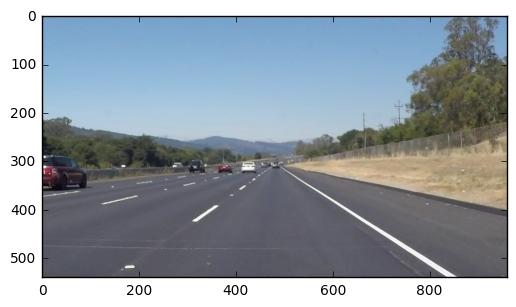

In [14]:
# Reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
# Printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

# **Helper Functions**
***
These are mainly functions provided with the project. I modified **draw_lines** and created **color_threshold**. 

In [15]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, y_ratio_upper, color=[255, 0, 0], thickness=5):
    """Returns the provided image with the provided lines averaged, extrapolated, and drawn."""
    
    ysize, xsize, _ = img.shape
    left_points = []
    right_points = []
    
    
    # The purpose of this value is to set a restriction on the valid slope 
    # values for the line segments generated by the Canny edge detection. In
    # this case, we ignore all line segments that are near to horizontal.
    #
    # ___   yes   ___
    #    ___   ___
    # no    ___    no
    #    ___   ___
    # ___   yes   ___
    slope_cutoff = 0.55
    
    # Seperates the endpoints of the line segments into two datasets, one for
    # the left and one for the right lane lines. Uses the following conditions:
    #     - Valid slope (see above)
    #     - Side of the image
    #         - Only points on the right side of the screen can be
    #           considered valid for the right_points set.
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2: slope = 9999999
            else: slope = ((y2-y1)/(x2-x1))
            
            if slope > slope_cutoff and x1 > xsize//2:
                right_points += [[x1,y1], [x2,y2]]
            elif slope < -slope_cutoff and x1 < xsize//2:
                left_points += [[x1,y1], [x2,y2]]
    
    right_points = np.array(right_points)
    left_points = np.array(left_points)
    
    # If either the left or right side had no valid line segments, break.
    # This is very rare with a propperly adjusted hough_lines.
    if right_points.size == 0 or left_points.size == 0:
        return
    
    # Run a linear regression over both datasets to find their best representative
    # line.
    right_slope, right_b = np.polyfit(right_points[:,0], right_points[:,1], 1)
    left_slope, left_b  = np.polyfit(left_points[:,0], left_points[:,1], 1)
    
    # Find the upper bound of the lines to be drawn.
    cutoff = int(y_ratio_upper*ysize)
    
    # Find the two points at the extremum of both lane lines. E.G. The point of
    # intersection of the left lane line with the cutoff and the bottom of the 
    # image. Stored in this format: (x1, y1, x2, y2)
    left_line = (int((cutoff-left_b)/left_slope), cutoff, int((ysize-left_b)/left_slope), ysize)
    right_line = (int((cutoff-right_b)/right_slope), cutoff, int((ysize-right_b)/right_slope), ysize)
    
    # Draw the predicted lane lines on the image.
    for x1,y1,x2,y2 in (left_line, right_line):
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_ratio_upper):
    """Returns an image with hough lines drawn.
    
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape + (3,), dtype=np.uint8)
    draw_lines(line_img, lines, y_ratio_upper)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def color_threshold(image, thresholds):
    """Returns an image with all pixels below the color threshold blacked out
    
    `thresholds` should be an iterable with values 
    (Red_Threshold, Green_Threshold, Blue_Threshold)
    """
    try:
        R, G, B = thresholds
    except:
        raise ValueError('Error in threshold values. Try a tuple with (R,G,B)')
    
    color_threshold = np.copy(image)
    threshold = (image[:,:,0] < R) | (image[:,:,1] < G) | (image[:,:,2] < B)
    color_threshold[threshold] = [0,0,0]
    return color_threshold

## Creating the Pipeline

Now for the fun part. How do we combine the helper fuinctions above to create an image pipeline which takes an image in, estimates the position of the lane lines, and returns an annotated image? The first step we need to take is to find the edges in our image, which are likely to be the lane lines. We can do this with our Canny edge detection function.

Let's start by getting an image to work with:

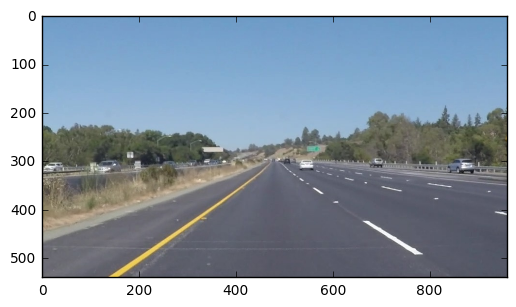

In [16]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(image)

Nice. OK now what? We can clearly see the lane lines, and we could easily draw some lines on the image by hand, but how do we teach our computer to do this for us? Let's start by identifying the locations in the image that are 'edges', AKA locations where the color from one pixel to the next is drastically different. 

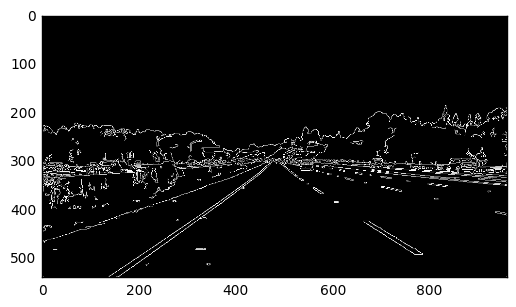

In [17]:
# First we convert our image to grayscale
gray = grayscale(image)

# Let's blur the image a bit to account for noise
gray_blur = gaussian_blur(gray, 5)

# Now we use canny edge detection
edges = canny(gray, 50, 150)

# Let's take a look
plt.imshow(edges, cmap='gray')

Not bad. Now we have the locations of all of the edges in the entire image, but all we need are the edges that are associated with the lane lines. 

If we make the assumptions that the lane lines will always stay in the same region of the image, the camera will never move, and that all images are the same size (we can relax this assumtion later), we can filter out a polygon in the center of the image where the lane lines are guaranteed to be!

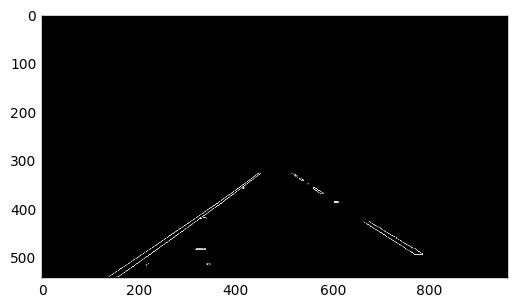

In [18]:
# Store the size of the image
ysize, xsize, _ = image.shape

# I messed around with different locations and found that this one worked pretty well
vertices = np.array([[(100, ysize), (440, 325), (520, 325), (900, ysize)]])

# Select only the pixels that are within the polygon defined by the above vertices.
masked_edges = region_of_interest(edges, vertices)

# Let's see how we did
plt.imshow(masked_edges, cmap='gray')

Just so we're clear about what's happening here, take a look at our region of interest in the original image

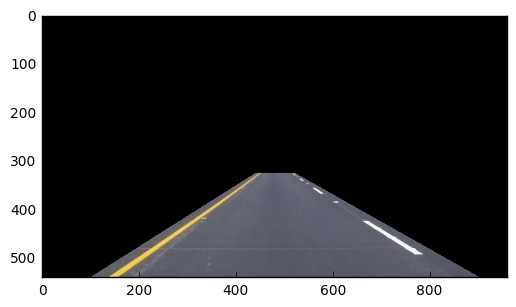

In [19]:
masked_color = region_of_interest(image, vertices)
plt.imshow(masked_color)

Despite a little bit of noise in the center of the  masked_edges image, I think we're good to move on to the next step! 

Now all we need to do is transform our edges into Hough space, find the line segments that define these edges, seperate the line segments into left and right sides, determine a line of best fit for each side, and extrapolate that line to the top and bottom. Easy!

In all seriousness, this was the bulk of the work involved with this code. For a full explanation of my approach to this problem, please see the comments of the draw_lines function and the explanation at the bottom of this notebook.

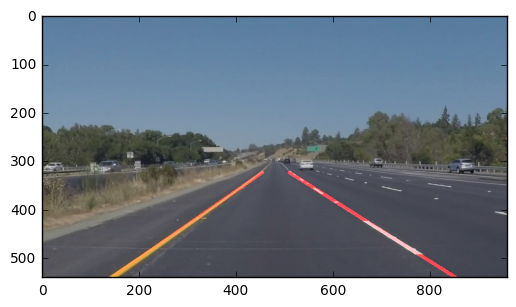

In [20]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 50    # maximum gap in pixels between connectable line segments
line_image = np.zeros_like(image) # blank image to draw on

# Predict the position of the lane lines.
lines = hough_lines(masked_edges, rho, theta, threshold, \
                    min_line_length, max_line_gap, 0.6)

# Draw the predicted lane lines on the original image
lines_edges = weighted_img(initial_img=image, img=lines)

# Let's see how we did
plt.imshow(lines_edges)

Perfect! The method we defined above has perfectly predicted the location of the lane lines in our image! Now we would like to expand this method to apply not only **one** image, but a **series** of images (a.k.a. a video!). To do this, we need to define a function that applies our steps above to an input image, and returns the result. 

I'm not going to walk through this process step by step until the end, but please feel free to read through the code and comments for my solution in the mean time! 

**Note:** I've added in some additional optimizations to our original method in the below code, which are commented in the code and explained in detail at the bottom of this notebook.

# **Lane Line Annotation Pipeline**

In [40]:
def process_image(image):
    if image.ndim != 3:
        raise ValueError('Image must have a Length, Width, and RGB dimension.')
    
    ysize, xsize, colors = image.shape
    
    assert colors == 3, 'Must be a RGB image.'
    
    gray = grayscale(image)
    gray_blur = gaussian_blur(gray, 5)
    
    # Calculate thresholds for Canny using Otsu's Method
    high_thresh, _ = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    
    edges = canny(gray_blur, low_thresh, high_thresh)
    
    # What percent of the image should each point in my polygon region use?
    x_ratio_outer = 0.12
    x_ratio_inner = 0.45
    y_ratio_upper = 0.6
    y_ratio_lower = 0.95
    
    # If your image is 100x100, the above ratios would produce these 
    # verticies:
    #     - (12, 95)
    #     - (45, 60)
    #     - (55, 60)
    #     - (88, 95)
    # This is necessary to handle varable image sizes.
    vertices = np.array([[
            (xsize*x_ratio_outer, ysize*y_ratio_lower),
            (xsize*x_ratio_inner, ysize*y_ratio_upper),
            (xsize*(1-x_ratio_inner), ysize*y_ratio_upper),
            (xsize*(1-x_ratio_outer), ysize*y_ratio_lower)
        ]], dtype='int32')
    
    #vertices = np.array([[(100, ysize), (440, 325), (510, 325), (900, ysize)]])
    
    # Select only the pixels that are within the above polygon.
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    line_image = np.zeros_like(image) # blank image to draw on
    
    # Predict the position of the lane lines.
    lines = hough_lines(masked_edges, rho, theta, threshold, \
                        min_line_length, max_line_gap, y_ratio_upper)
    
    # Draw the predicted lane lines on the original image
    lines_edges = weighted_img(initial_img=image, img=lines)
    return lines_edges

Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7f709b8fd208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/moviepy/video/io/VideoFileClip.py", line 86, in __del__
    del self.reader
AttributeError: reader


# Test on Videos

Now that our pipeline is defined and ready to go, we can try it out and see how it performs.

We can test our solution on two provided videos:

    - solidWhiteRight.mp4

    - solidYellowLeft.mp4

And an additional challenge video:

    - challenge.mp4

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [33]:
white_output = 'Videos/Predictions/white.mp4'
clip1 = VideoFileClip("Videos/Originals/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

68.0 136.0
[MoviePy] >>>> Building video Videos/Predictions/white.mp4
[MoviePy] Writing video Videos/Predictions/white.mp4


  5%|▌         | 12/222 [00:00<00:01, 115.75it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 16%|█▌        | 35/222 [00:00<00:01, 112.05it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


 25%|██▌       | 56/222 [00:00<00:01, 95.45it/s] 

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0


 32%|███▏      | 72/222 [00:00<00:01, 81.53it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0


 36%|███▌      | 80/222 [00:00<00:01, 74.48it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 40%|████      | 89/222 [00:01<00:01, 76.72it/s]

68.0 136.0
68.0 136.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 44%|████▎     | 97/222 [00:01<00:01, 75.82it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 47%|████▋     | 105/222 [00:01<00:01, 74.29it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0


 51%|█████▏    | 114/222 [00:01<00:01, 77.32it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 55%|█████▍    | 122/222 [00:01<00:01, 76.08it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 59%|█████▉    | 131/222 [00:01<00:01, 79.30it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 63%|██████▎   | 139/222 [00:01<00:01, 75.85it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 66%|██████▌   | 147/222 [00:01<00:01, 74.64it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 70%|██████▉   | 155/222 [00:01<00:00, 75.50it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 74%|███████▍  | 164/222 [00:02<00:00, 77.15it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 77%|███████▋  | 172/222 [00:02<00:00, 77.89it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 82%|████████▏ | 181/222 [00:02<00:00, 80.82it/s]

67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 86%|████████▌ | 190/222 [00:02<00:00, 81.65it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 90%|████████▉ | 199/222 [00:02<00:00, 81.55it/s]

67.5 135.0
67.5 135.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 98%|█████████▊| 217/222 [00:02<00:00, 80.21it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


100%|█████████▉| 221/222 [00:02<00:00, 81.61it/s]


68.5 137.0
[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Predictions/white.mp4 

CPU times: user 2.41 s, sys: 184 ms, total: 2.59 s
Wall time: 3.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Looking good! Our pipeline generalized perfectly from a single image to a video! However, this video was easy-mode. Let's see how our pipeline performs on a trickier video with more noise and different colored lane lines.

In [36]:
yellow_output = 'Videos/Predictions/yellow.mp4'
clip2 = VideoFileClip('Videos/Originals/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

68.5 137.0
[MoviePy] >>>> Building video Videos/Predictions/yellow.mp4
[MoviePy] Writing video Videos/Predictions/yellow.mp4


  1%|▏         | 10/682 [00:00<00:06, 97.37it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


  5%|▍         | 32/682 [00:00<00:06, 101.44it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


  7%|▋         | 51/682 [00:00<00:06, 91.83it/s] 

68.0 136.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 10%|▉         | 68/682 [00:00<00:07, 84.26it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0


 12%|█▏        | 84/682 [00:00<00:07, 78.75it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 15%|█▍        | 101/682 [00:01<00:07, 78.77it/s]

67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 17%|█▋        | 117/682 [00:01<00:07, 73.62it/s]

67.0 134.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0
66.5 133.0
66.5 133.0


 20%|█▉        | 135/682 [00:01<00:07, 76.96it/s]

66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0


 22%|██▏       | 153/682 [00:01<00:06, 82.06it/s]

66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.0 132.0
66.0 132.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0


 24%|██▍       | 162/682 [00:01<00:06, 78.72it/s]

66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
65.5 131.0


 25%|██▌       | 171/682 [00:02<00:06, 80.37it/s]

65.5 131.0
65.5 131.0


 26%|██▋       | 180/682 [00:02<00:06, 79.07it/s]

65.5 131.0
65.5 131.0
65.5 131.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0


 28%|██▊       | 189/682 [00:02<00:06, 80.15it/s]

66.0 132.0
66.0 132.0
66.0 132.0


 29%|██▉       | 198/682 [00:02<00:05, 80.78it/s]

66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0


 32%|███▏      | 215/682 [00:02<00:05, 78.30it/s]

65.5 131.0
65.0 130.0
65.5 131.0
65.0 130.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
66.0 132.0
66.0 132.0
66.0 132.0
66.0 132.0
65.5 131.0
65.5 131.0
65.5 131.0


 34%|███▍      | 232/682 [00:02<00:05, 75.73it/s]

65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0


 35%|███▌      | 240/682 [00:03<00:06, 68.84it/s]

65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.5 131.0
65.0 130.0
65.0 130.0
65.0 130.0
65.0 130.0
65.5 131.0


 37%|███▋      | 255/682 [00:03<00:06, 64.43it/s]

65.5 131.0
65.5 131.0
66.0 132.0
66.0 132.0
66.0 132.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0


 40%|███▉      | 270/682 [00:03<00:06, 64.90it/s]

66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0
66.5 133.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0


 42%|████▏     | 287/682 [00:03<00:05, 73.47it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 45%|████▍     | 304/682 [00:03<00:04, 75.88it/s]

67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 47%|████▋     | 320/682 [00:04<00:04, 76.56it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 49%|████▉     | 336/682 [00:04<00:04, 77.12it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
66.5 133.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 51%|█████     | 345/682 [00:04<00:04, 79.12it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.0 134.0


 52%|█████▏    | 354/682 [00:04<00:04, 79.79it/s]

67.0 134.0
67.0 134.0
67.0 134.0


 53%|█████▎    | 363/682 [00:04<00:04, 77.48it/s]

67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0


 55%|█████▍    | 372/682 [00:04<00:03, 78.92it/s]

67.0 134.0
67.0 134.0
67.0 134.0


 56%|█████▌    | 380/682 [00:04<00:03, 77.42it/s]

67.0 134.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0


 57%|█████▋    | 388/682 [00:04<00:03, 76.06it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


 58%|█████▊    | 396/682 [00:05<00:03, 74.13it/s]

67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 61%|██████    | 413/682 [00:05<00:03, 74.94it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 63%|██████▎   | 430/682 [00:05<00:03, 77.21it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0


 65%|██████▌   | 446/682 [00:05<00:03, 75.82it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


 68%|██████▊   | 464/682 [00:05<00:02, 78.94it/s]

68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 71%|███████   | 481/682 [00:06<00:02, 76.74it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
67.5 135.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


 73%|███████▎  | 498/682 [00:06<00:02, 80.63it/s]

68.0 136.0
68.0 136.0
68.0 136.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0
67.5 135.0
67.5 135.0
67.0 134.0
67.0 134.0
67.0 134.0


 74%|███████▍  | 507/682 [00:06<00:02, 80.25it/s]

67.0 134.0
67.0 134.0
66.5 133.0
66.5 133.0
66.5 133.0
66.0 132.0
66.0 132.0
66.0 132.0
65.5 131.0
65.5 131.0
65.0 130.0
64.5 129.0


 76%|███████▌  | 516/682 [00:06<00:02, 78.52it/s]

64.5 129.0
64.0 128.0
64.0 128.0
64.0 128.0


 77%|███████▋  | 525/682 [00:06<00:01, 79.71it/s]

64.0 128.0
64.0 128.0
64.5 129.0
64.5 129.0
64.5 129.0
64.5 129.0
64.5 129.0
64.0 128.0
64.0 128.0
64.0 128.0
64.5 129.0
65.0 130.0


 78%|███████▊  | 533/682 [00:06<00:01, 76.04it/s]

65.5 131.0
65.5 131.0
66.5 133.0
66.5 133.0


 79%|███████▉  | 542/682 [00:06<00:01, 78.21it/s]

66.5 133.0
66.5 133.0
66.5 133.0
67.5 135.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


 81%|████████  | 550/682 [00:07<00:01, 76.79it/s]

68.5 137.0
68.5 137.0
68.5 137.0


 82%|████████▏ | 558/682 [00:07<00:01, 76.04it/s]

69.0 138.0
68.5 137.0
69.0 138.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0


 83%|████████▎ | 567/682 [00:07<00:01, 77.77it/s]

69.0 138.0
69.0 138.0
69.0 138.0


 84%|████████▍ | 576/682 [00:07<00:01, 79.36it/s]

69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0


 87%|████████▋ | 592/682 [00:07<00:01, 78.23it/s]

69.0 138.0
69.5 139.0
69.5 139.0
69.5 139.0
69.5 139.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.5 139.0
69.5 139.0
69.5 139.0
69.5 139.0
69.0 138.0


 90%|████████▉ | 611/682 [00:07<00:00, 81.28it/s]

69.0 138.0
69.0 138.0
69.0 138.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
69.0 138.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


 92%|█████████▏| 629/682 [00:08<00:00, 80.68it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0


 95%|█████████▍| 647/682 [00:08<00:00, 79.07it/s]

68.5 137.0
68.5 137.0
69.0 138.0
68.5 137.0
68.5 137.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
69.0 138.0
68.5 137.0


 97%|█████████▋| 663/682 [00:08<00:00, 79.01it/s]

68.5 137.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.5 137.0
68.5 137.0
68.5 137.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0


100%|█████████▉| 681/682 [00:08<00:00, 81.06it/s]

68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
68.0 136.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0
67.5 135.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Predictions/yellow.mp4 

CPU times: user 7.7 s, sys: 616 ms, total: 8.32 s
Wall time: 9.09 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Not bad! But not perfect... Unlike the last video, we can start to see some chinks in our methods' armor. Whenever there is a marking close to the yellow line on the left, our lane line prediction jumps our to greet it for a split second. However, the predictions are very accurate for the **vast** majority of the video, so for now we will take the accuracy hit, move on, and hope it doesn't come back to bite us.

## Optional Challenge

This video is an order of magnitude more difficult than the previous videos, but lets see how our pipeline performs and see if we can learn anything in the process.

In [42]:
challenge_output = 'Videos/Predictions/extra.mp4'
clip2 = VideoFileClip('Videos/Originals/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Videos/Predictions/extra.mp4
[MoviePy] Writing video Videos/Predictions/extra.mp4


100%|██████████| 251/251 [00:05<00:00, 42.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Predictions/extra.mp4 

CPU times: user 5.12 s, sys: 456 ms, total: 5.58 s
Wall time: 6.73 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

We can immediately see that our pipeline does not perform **nearly** as well in these conditions as it did in the previous videos. To understand why, lets modify the pipeline to display the edge markings with the predicted lines.

In [47]:
def process_image(image):
    if image.ndim != 3:
        raise ValueError('Image must have a Length, Width, and RGB dimension.')
    
    ysize, xsize, colors = image.shape
    
    assert colors == 3, 'Must be a RGB image.'
    
    gray = grayscale(image)
    gray_blur = gaussian_blur(gray, 5)
    
    # Calculate thresholds for Canny using Otsu's Method
    high_thresh, _ = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    
    edges = canny(gray_blur, 80, 180)
    
    # What percent of the image should each point in my polygon region use?
    x_ratio_outer = 0.12
    x_ratio_inner = 0.45
    y_ratio_upper = 0.6
    y_ratio_lower = 0.95
    
    # If your image is 100x100, the above ratios would produce these 
    # verticies:
    #     - (12, 95)
    #     - (45, 60)
    #     - (55, 60)
    #     - (88, 95)
    # This is necessary to handle varable image sizes.
    vertices = np.array([[
            (xsize*x_ratio_outer, ysize*y_ratio_lower),
            (xsize*x_ratio_inner, ysize*y_ratio_upper),
            (xsize*(1-x_ratio_inner), ysize*y_ratio_upper),
            (xsize*(1-x_ratio_outer), ysize*y_ratio_lower)
        ]], dtype='int32')
    
    #vertices = np.array([[(100, ysize), (440, 325), (510, 325), (900, ysize)]])
    
    # Select only the pixels that are within the above polygon.
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    line_image = np.zeros_like(image) # blank image to draw on
    
    # Predict the position of the lane lines.
    lines = hough_lines(masked_edges, rho, theta, threshold, \
                        min_line_length, max_line_gap, y_ratio_upper)
    
    # Create a 'color' image of our masked edges to pipe into the output
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
    
    # Draw the predicted lane lines on the masked edges
    lines_edges = weighted_img(initial_img=color_edges, img=lines)
    return lines_edges

In [48]:
challenge_output = 'Videos/Predictions/extra_lines.mp4'
clip2 = VideoFileClip('Videos/Originals/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Videos/Predictions/extra_lines.mp4
[MoviePy] Writing video Videos/Predictions/extra_lines.mp4


100%|██████████| 251/251 [00:04<00:00, 59.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Predictions/extra_lines.mp4 

CPU times: user 4.38 s, sys: 328 ms, total: 4.7 s
Wall time: 4.37 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Reflections

We can immediately see what went wrong in the challenge video. The canny edge detection was unable to distinguish between the light section of the road and the yellow line **at all**. In addition, the curve of the road was **much** greater than our previous experiences, making the right lane line error out at the apex, which happened to also be in the section of light road. 

Possible solutions for these issues are as follows:
    - Mess with the canny edge detection settings to recognize the difference between light road and yellow lane  lines.
    
    - Shorten the upper bound of the polygon to remove some noise from the linear fit
        - A drawback with this solution would be less information about the future position of the vehicle
        
    - Modify the lane line predictions to be higher order polynomials
        - This could lead to overfitting and 'swervy' driving
        
    - Create a moving average of lane line predictions (maybe 10 frames?)
        - Could smooth out the 'jumpiness' we see in the left lane line
        - May cause a crash in sharper turns, as the 'smoothed' lines would not represent reality
    
    - Combine some or all of the above proposals
    
    - Find a better method :)

All in all, I think the pipeline we created was a very good first attempt at lane line detection, and a great learning experience. I am looking forward to learning more sophisticated methods to accomplish this task in the future lessons!

## Pipeline Explanation

As a last remark, I will provide a detailed explanation of the method I used to predict the lane lines. The most complex part of the method was to predict the lane lines location given the line segments generated with Canny edge detection. Let's break it down step-by-step:

The Canny edge detection returns a list of line segments, all of which are comprised of two points, (x1,y1) and (x2,y2). Using these points, we can define the slope of the line segment as (y2-y1)/(x2-x1).

Now the first thing we need to do is separate these line segments into those that relate to the **left** lane line, those that relate to the **right** lane line, and those that are **irrelevant**. To do this, I created several conditions:
    - The left lane line is on the left side of the screen. Only line segments with the bottom point on the left  side of the screen can have a vote toward the prediction of the left lane line. Vice versa for the right.
    - The lane lines usually have inverse slopes (with a tolerance), and near-horizontal line segments are        unlikely to correspond to a lane line. Only allow line segments whose abs(slope) 
      is greater than 0.55
    - The left lane line has a negative slope, and the right lane line has a positive slope. Store the valid      line segments in a table for each lane line.
Only line segments whose properties aggreed with these conditions would be stored in their respective tables. Now that we have two lists of line segments that are likely to correspond to the left and right lane lines, we need to use them to make a prediction. The key intuition in my approach is that a line segment is defined by **points**. Essentially what we have in our tables are a list of points that are likely to fall on a line. This is a regression problem!

Therefore, to solve for a prediction of the position of the left and right lane lines, all we have to do is run a linear regression over our two tables! Once we have our preditions, the remaining code solves for the intersection of our predicted lines with the upper and lower bounds of our polygon, and draws the predicted lines onto the original image.

If you have any questions or suggestions, feel free to reach out to me at jpthalman@gmail.com.